# Parallel Evaluation in JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/06-parallelism.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/jax-101/06-parallelism.ipynb)

*Authors: Vladimir Mikulik & Roman Ring*

In this section we will discuss the facilities built into JAX for single-program, multiple-data (SPMD) code.

SPMD refers to a parallelism technique where the same computation (e.g., the forward pass of a neural net) is run on different input data (e.g., different inputs in a batch) in parallel on different devices (e.g., several TPUs).

Conceptually, this is not very different from vectorisation, where the same operations occur in parallel in different parts of memory on the same device. We have already seen that vectorisation is supported in JAX as a program transformation, `jax.vmap`. JAX supports device parallelism analogously, using `jax.pmap` to transform a function written for one device into a function that runs in parallel on multiple devices. This colab will teach you all about it.

## TPU Setup

This notebook requires multiple accelerators and we recommend running it using Kaggle TPU VMs.

Next run the following to see the TPU devices you have available:

In [1]:
import jax
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

## The basics

The most basic use of `jax.pmap` is completely analogous to `jax.vmap`, so let's return to the convolution example from the [Vectorisation notebook](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/03-vectorization.ipynb).

In [2]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

Now, let's convert our `convolve` function into one that runs on entire batches of data. In anticipation of spreading the batch across several devices, we'll make the batch size equal to the number of devices:

In [3]:
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[0, 1, 2, 3, 4]])

In [4]:
ws

array([[2., 3., 4.]])

As before, we can vectorise using `jax.vmap`:

In [5]:
jax.vmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

To spread out the computation across multiple devices, just replace `jax.vmap` with `jax.pmap`:

In [6]:
jax.pmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

Note that the parallelized `convolve` returns a `ShardedDeviceArray`. That is because the elements of this array are sharded across all of the devices used in the parallelism. If we were to run another parallel computation, the elements would stay on their respective devices, without incurring cross-device communication costs.

In [7]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[ 78., 138., 198.]], dtype=float32)

The outputs of the inner `jax.pmap(convolve)` never left their devices when being fed into the outer `jax.pmap(convolve)`.

## Specifying `in_axes`

Like with `vmap`, we can use `in_axes` to specify whether an argument to the parallelized function should be broadcast (`None`), or whether it should be split along a given axis. Note, however, that unlike `vmap`, only the leading axis (`0`) is supported by `pmap` at the time of writing this guide.

In [8]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

Array([[11., 20., 29.]], dtype=float32)

Notice how we get equivalent output to what we observe above with `jax.pmap(convolve)(xs, ws)`, where we manually replicated `w` when creating `ws`. Here, it is replicated via broadcasting, by specifying it as `None` in `in_axes`.

Keep in mind that when calling the transformed function, the size of the specified axis in arguments must not exceed the number of devices available to the host.

## `pmap` and `jit`

`jax.pmap` JIT-compiles the function given to it as part of its operation, so there is no need to additionally `jax.jit` it.

## Communication between devices

The above is enough to perform simple parallel operations, e.g. batching a simple MLP forward pass across several devices. However, sometimes we need to pass information between the devices. For example, perhaps we are interested in normalizing the output of each device so they sum to 1.
For that, we can use special [collective ops](https://jax.readthedocs.io/en/latest/jax.lax.html#parallel-operators) (such as the `jax.lax.p*` ops `psum`, `pmean`, `pmax`, ...). In order to use the collective ops we must specify the name of the `pmap`-ed axis through `axis_name` argument, and then refer to it when calling the op. Here's how to do that:

In [9]:
def normalized_convolution(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  output = jnp.array(output)
  return output / jax.lax.psum(output, axis_name='p')

jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[1., 1., 1.]], dtype=float32)

The `axis_name` is just a string label that allows collective operations like `jax.lax.psum` to refer to the axis bound by `jax.pmap`. It can be named anything you want -- in this case, `p`. This name is essentially invisible to anything but those functions, and those functions use it to know which axis to communicate across.

`jax.vmap` also supports `axis_name`, which allows `jax.lax.p*` operations to be used in the vectorisation context in the same way they would be used in a `jax.pmap`:

In [10]:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[1., 1., 1.]], dtype=float32)

Note that `normalized_convolution` will no longer work without being transformed by `jax.pmap` or `jax.vmap`, because `jax.lax.psum` expects there to be a named axis (`'p'`, in this case), and those two transformations are the only way to bind one.

## Nesting `jax.pmap` and `jax.vmap`

The reason we specify `axis_name` as a string is so we can use collective operations when nesting `jax.pmap` and `jax.vmap`. For example:

```python
jax.vmap(jax.pmap(f, axis_name='i'), axis_name='j')
```

A `jax.lax.psum(..., axis_name='i')` in `f` would refer only to the pmapped axis, since they share the `axis_name`. 

In general, `jax.pmap` and `jax.vmap` can be nested in any order, and with themselves (so you can have a `pmap` within another `pmap`, for instance).

## Example

Here's an example of a regression training loop with data parallelism, where each batch is split into sub-batches which are evaluated on separate devices.

There are two places to pay attention to:
* the `update()` function
* the replication of parameters and splitting of data across devices.

If this example is too confusing, you can find the same example, but without parallelism, in the next notebook, [State in JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb). Once that example makes sense, you can compare the differences to understand how parallelism changes the picture.

In [11]:
from typing import NamedTuple, Tuple
import functools

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * xs + params.bias
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

# So far, the code is identical to the single-device case. Here's what's new:


# Remember that the `axis_name` is just an arbitrary string label used
# to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
# 'num_devices', but could have used anything, so long as `pmean` used the same.
@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> Tuple[Params, jnp.ndarray]:
  """Performs one SGD update step on params using the given data."""

  # Compute the gradients on the given minibatch (individually on each device).
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # Also combine the loss. Unnecessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Each device performs its own update, but since we start with the same params
  # and synchronise gradients, the params stay in sync.
  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grads)

  return new_params, loss

Here's how `update()` works:

Undecorated and without the `pmean`s, `update()` takes data tensors of shape `[batch, ...]`, computes the loss function on that batch and evaluates its gradients.

We want to spread the `batch` dimension across all available devices. To do that, we add a new axis using `pmap`. The arguments to the decorated `update()` thus need to have shape `[num_devices, batch_per_device, ...]`. So, to call the new `update()`, we'll need to reshape data batches so that what used to be `batch` is reshaped to `[num_devices, batch_per_device]`. That's what `split()` does below. Additionally, we'll need to replicate our model parameters, adding the `num_devices` axis. This reshaping is how a pmapped function knows which devices to send which data.

At some point during the update step, we need to combine the gradients computed by each device -- otherwise, the updates performed by each device would be different. That's why we use `jax.lax.pmean` to compute the mean across the `num_devices` axis, giving us the average gradient of the batch. That average gradient is what we use to compute the update.

Aside on naming: here, we use `num_devices` for the `axis_name` for didactic clarity while introducing `jax.pmap`. However, in some sense that is tautologous: any axis introduced by a pmap will represent a number of devices. Therefore, it's common to see the axis be named something semantically meaningful, like `batch`, `data` (signifying data parallelism) or `model` (signifying model parallelism).

In [12]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.PRNGKey(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

So far, we've just constructed arrays with an additional leading dimension. The params are all still all on the host (CPU). `pmap` will communicate them to the devices when `update()` is first called, and each copy will stay on its own device subsequently. You can tell because they are a DeviceArray, not a ShardedDeviceArray:

In [13]:
type(replicated_params.weight)

jaxlib.xla_extension.ArrayImpl

The params will become a ShardedDeviceArray when they are returned by our pmapped `update()` (see further down).

We do the same to the data:

In [14]:
def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

type(x_split)

numpy.ndarray

The data is just a reshaped vanilla NumPy array. Hence, it cannot be anywhere but on the host, as NumPy runs on CPU only. Since we never modify it, it will get sent to the device at each `update` call, like in a real pipeline where data is typically streamed from CPU to the device at each step.

In [15]:
def type_after_update(name, obj):
  print(f"after first `update()`, `{name}` is a", type(obj))

# Actual training loop.
for i in range(1000):

  # This is where the params and data gets communicated to devices:
  replicated_params, loss = update(replicated_params, x_split, y_split)

  # The returned `replicated_params` and `loss` are now both ShardedDeviceArrays,
  # indicating that they're on the devices.
  # `x_split`, of course, remains a NumPy array on the host.
  if i == 0:
    type_after_update('replicated_params.weight', replicated_params.weight)
    type_after_update('loss', loss)
    type_after_update('x_split', x_split)

  if i % 100 == 0:
    # Note that loss is actually an array of shape [num_devices], with identical
    # entries, because each device returns its copy of the loss.
    # So, we take the first element to print it.
    print(f"Step {i:3d}, loss: {loss[0]:.3f}")


# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss: 5.703
Step 100, loss: 0.877
Step 200, loss: 0.303
Step 300, loss: 0.230
Step 400, loss: 0.221
Step 500, loss: 0.219
Step 600, loss: 0.219
Step 700, loss: 0.219
Step 800, loss: 0.219
Step 900, loss: 0.219


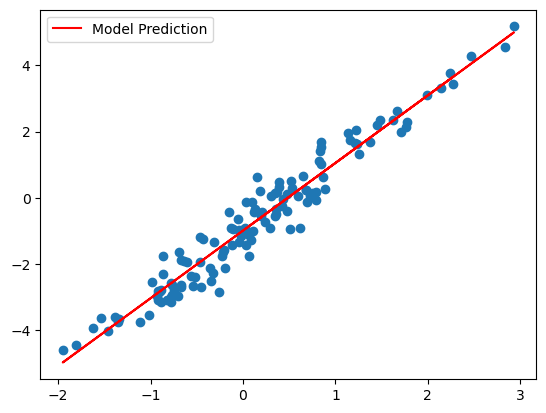

In [16]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

## Aside: hosts and devices in JAX

When running on TPU, the idea of a 'host' becomes important. A host is the CPU that manages several devices. A single host can only manage so many devices (usually 8), so when running very large parallel programs, multiple hosts are needed, and some finesse is required to manage them.

In [17]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

When running on CPU you can always emulate an arbitrary number of devices with a nifty `--xla_force_host_platform_device_count` XLA flag, e.g. by executing the following before importing JAX:
```python
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
jax.devices()
```
```
[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]
```
This is especially useful for debugging and testing locally or even for prototyping in Colab since a CPU runtime is faster to (re-)start.